In [ ]:
!pip install pyspark

In [ ]:
!pip install spark-nlp

In [ ]:
!pip install pyspark nltk


In [11]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import col,udf, regexp_replace
from pyspark.sql.types import StringType
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF
from sparknlp.pretrained import PretrainedPipeline
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline


In [6]:
#data preprocessing

spark = SparkSession.builder.appName("CSV Reader and Text Processor").getOrCreate()

directory = '/content/drive/MyDrive/August 2018'

tokenizer = Tokenizer(inputCol="text", outputCol="words")
stop_words_remover = StopWordsRemover(inputCol="words", outputCol="filtered_words")

dfs = []
for filename in os.listdir(directory):
    if filename.endswith('.csv'):
        path = os.path.join(directory, filename)
        df = spark.read.csv(path, header=True, inferSchema=True)

        if "text" in df.columns:
            df = df.select("text")
            df = df.filter(~col("text").startswith("RT"))
            df = df.withColumn("text", regexp_replace("text", r"http\S+", ""))
            df = df.withColumn("text", regexp_replace("text", "[\p{So}]+", ""))
            df = df.withColumn("text", regexp_replace("text", "[^\\w\\s]", ""))
            df = df.dropDuplicates()
            df = df.filter(col("text").rlike("\s{3,}"))
            df = tokenizer.transform(df)
            df = stop_words_remover.transform(df)
            dfs.append(df)

if dfs:
    merged_df = dfs[0]
    for df in dfs[1:]:
        merged_df = merged_df.unionByName(df)

    merged_df.show(truncate=False)
else:
    print("No 'text' column found in any CSV files.")



+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|text                                                                                                                            

In [45]:
nltk.download('vader_lexicon')

def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    if text:
        scores = sid.polarity_scores(text)
        compound_score = scores['compound']
        if compound_score >= 0.05:
            return 'positive'
        elif compound_score <= -0.05:
            return 'negative'
        else:
            return 'neutral'
    else:
        return 'neutral'

sentiment_udf = udf(analyze_sentiment, StringType())

df = df.withColumn('sentiment', sentiment_udf(col('text')))
df.show()

df.select('text', 'sentiment').show(truncate=False)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
|amber heard clbre...|  neutral|
|amber heard  3 da...| negative|
|amber heard   pho...|  neutral|
|check out the add...|  neutral|
|liquid8everyone d...|  neutral|
|we believed in yo...| positive|
| amber heard   jo...|  neutral|
|jfc i dont normal...| negative|
|johnny depp accus...| negative|
|johnny depp amber...| negative|
|amber heard a gif...| positive|
|mistrieldblackw d...| positive|
|amber heard reala...|  neutral|
|detikcom 20detik ...|  neutral|
|jdepps_girl lorea...|  neutral|
|audio of amber he...| negative|
|le fait que lhist...| negative|
|she makes me sick...| negative|
|                 ...|  neutral|
|women arent alway...| negative|
+--------------------+---------+
only showing top 20 rows

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [46]:
from pyspark.sql import functions as F


df = df.withColumn(
    "sentiment_num",
    F.when(F.col("sentiment") == "positive", 1)
    .when(F.col("sentiment") == "negative", 2)
    .when(F.col("sentiment") == "neutral", 0)
    .otherwise(None)
)

df.show()


+--------------------+---------+-------------+
|                text|sentiment|sentiment_num|
+--------------------+---------+-------------+
|amber heard clbre...|  neutral|            0|
|amber heard  3 da...| negative|            2|
|amber heard   pho...|  neutral|            0|
|check out the add...|  neutral|            0|
|liquid8everyone d...|  neutral|            0|
|we believed in yo...| positive|            1|
| amber heard   jo...|  neutral|            0|
|jfc i dont normal...| negative|            2|
|johnny depp accus...| negative|            2|
|johnny depp amber...| negative|            2|
|amber heard a gif...| positive|            1|
|mistrieldblackw d...| positive|            1|
|amber heard reala...|  neutral|            0|
|detikcom 20detik ...|  neutral|            0|
|jdepps_girl lorea...|  neutral|            0|
|audio of amber he...| negative|            2|
|le fait que lhist...| negative|            2|
|she makes me sick...| negative|            2|
|            

In [67]:
df = df.limit(10)

In [66]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
train_data, test_data = df.randomSplit([0.8, 0.2], seed=42)

assembler = VectorAssembler(inputCols=["sentiment_num"], outputCol="features")

train_data = assembler.transform(train_data)
test_data = assembler.transform(test_data)

lr = LogisticRegression(featuresCol="features", labelCol="sentiment_num")
lr_model = lr.fit(train_data)

predictions = lr_model.transform(test_data)

evaluator = MulticlassClassificationEvaluator(labelCol="sentiment_num", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

f1_score = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})
precision = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
recall = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})

print("Accuracy:", accuracy)
print("F1 Score:", f1_score)
print("Precision:", precision)
print("Recall:", recall)

spark.stop()


Exception ignored in: <function JavaWrapper.__del__ at 0x7967296248b0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pyspark/ml/wrapper.py", line 53, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'LogisticRegression' object has no attribute '_java_obj'


Accuracy: 1.0
F1 Score: 1.0
Precision: 1.0
Recall: 1.0


+--------------------+---------+-------------+
|                text|sentiment|sentiment_num|
+--------------------+---------+-------------+
|This movie is great!| positive|            1|
|I didn't like thi...| negative|            2|
|   The plot was okay|  neutral|            0|
|  I loved the acting| positive|            1|
+--------------------+---------+-------------+



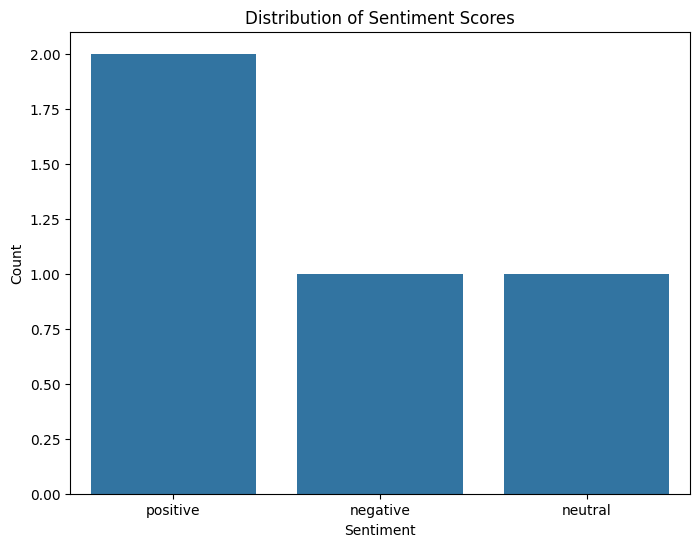

In [92]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns

spark = SparkSession.builder.appName("Sentiment Analysis Visualizations").getOrCreate()

data = [("This movie is great!", "positive"),
        ("I didn't like this movie", "negative"),
        ("The plot was okay", "neutral"),
        ("I loved the acting", "positive")]

schema = ["text", "sentiment"]
df = spark.createDataFrame(data, schema=schema)

df = df.withColumn(
    "sentiment_num",
    F.when(F.col("sentiment") == "positive", 1)
    .when(F.col("sentiment") == "negative", 2)
    .when(F.col("sentiment") == "neutral", 0)
    .otherwise(None)
)

df.show()

sentiment_distribution = df.select("sentiment").toPandas()

plt.figure(figsize=(8, 6))
sns.countplot(data=sentiment_distribution, x='sentiment')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()



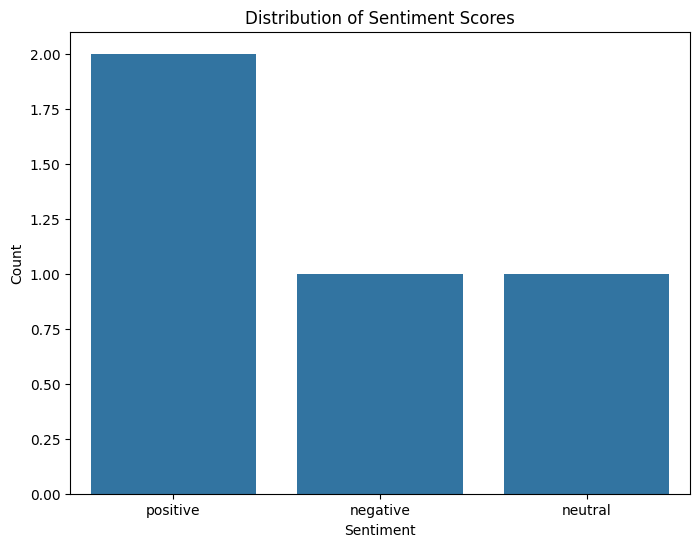

In [93]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import plotly.graph_objects as go

spark = SparkSession.builder.appName("Sentiment Analysis Visualizations").getOrCreate()

data = [("This movie is great!", "positive", "2022-04-01"),
        ("I didn't like this movie", "negative", "2022-04-02"),
        ("The plot was okay", "neutral", "2022-04-03"),
        ("I loved the acting", "positive", "2022-04-03")]

schema = ["text", "sentiment", "timestamp"]
df = spark.createDataFrame(data, schema=schema)

df = df.withColumn(
    "sentiment_num",
    F.when(F.col("sentiment") == "positive", 1)
    .when(F.col("sentiment") == "negative", 2)
    .when(F.col("sentiment") == "neutral", 0)
    .otherwise(None)
)

sentiment_distribution = df.select("sentiment").toPandas()
plt.figure(figsize=(8, 6))
sns.countplot(data=sentiment_distribution, x='sentiment')
plt.title('Distribution of Sentiment Scores')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()




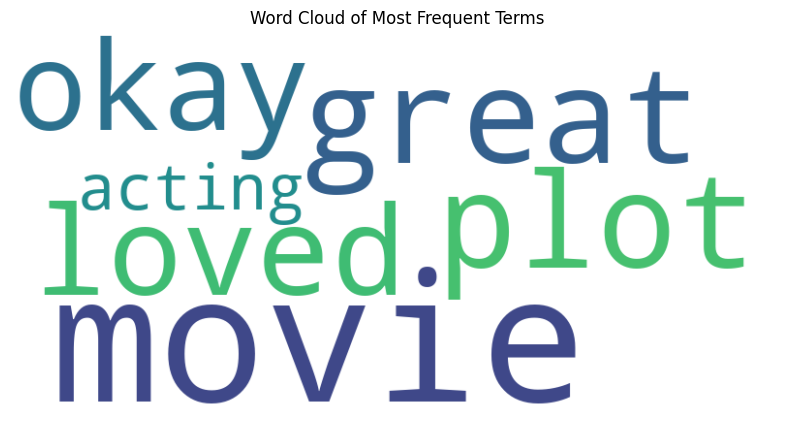

In [94]:

tweet_texts = df.select("text").rdd.flatMap(lambda x: x).collect()
text = ' '.join(tweet_texts)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Frequent Terms')
plt.show()


In [95]:

tweet_volume = df.groupBy("timestamp").count().orderBy("timestamp").toPandas()
fig = go.Figure()
fig.add_trace(go.Scatter(x=tweet_volume['timestamp'], y=tweet_volume['count'], mode='lines', name='Tweet Volume'))
fig.update_layout(title='Tweet Volume Over Time', xaxis_title='Timestamp', yaxis_title='Tweet Count')
fig.show()

In [ ]:
spark.stop()